In [1]:
import sys
sys.path.append('/remote-home/rpluo/lrp_project/FDU-DeepLearningNeuralNetwork/final_homework/InverseForm')
import torch
from models.model_loader import load_model
from models.ocrnet import HRNet_Mscale
from utils.config import assert_and_infer_cfg,cfg
from runx.logx import logx
from pathlib import Path
from torchvision.datasets import ImageFolder
import torchvision.transforms as standard_transforms
import torchvision
from PIL import Image
# laod model
logx.initialize(logdir='logs',
                    tensorboard=True,
                    global_rank=0)
model_path = '../InverseForm/checkpoints/hrnet48_OCR_HMS_IF_checkpoint.pth'
arch = 'ocrnet.HRNet_Mscale'
result_path = None
num_classes = 19
assert_and_infer_cfg(None, 0, False, False, arch, '48', True, True)
checkpoint = torch.load(model_path, map_location=torch.device('cpu'))
net = HRNet_Mscale(num_classes, None, has_edge_head=False)
load_model(net, checkpoint)
net.to('cuda:0')
# load image

vedio_img_dir = 'data/images'
vedio_img_list = Path(vedio_img_dir).glob('*.jpg')
mean_std = (cfg.DATASET.MEAN, cfg.DATASET.STD)
val_input_transform = standard_transforms.Compose([
    standard_transforms.ToTensor(),
    standard_transforms.Normalize(*mean_std)
])
img_path = vedio_img_list.__next__()

/remote-home/rpluo/miniconda3/envs/cuda10.1/lib/python3.7/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Using regular batch norm
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Dataset: Cityscapes
Number of classes: 19
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Trunk: hrnetv2


In [3]:
import torch.nn.functional as F
net.eval()
with torch.no_grad():
    image = Image.open(img_path)
    h,w = image.size
    image = image.resize((int(h/2),int(w/2)))
    origin_img = image.copy() 
    image = val_input_transform(image)
    image = image.unsqueeze(0)
    input_dict = {'images':image.cuda()}
    output = net(input_dict)
    pred = output['pred'][0]

In [ ]:
mask = F.softmax(pred, dim=0).max(0).indices

In [12]:
torch.sum(mask[:,0,0])

tensor(0.0352, device='cuda:0')

In [4]:
import numpy as np
def colormap(n):
    cmap=np.zeros([n, 3]).astype(np.uint8)
    cmap[0,:] = np.array([ 0,  0,  0])
    cmap[1,:] = np.array([244, 35,232])
    cmap[2,:] = np.array([ 70, 70, 70])
    cmap[3,:] = np.array([ 102,102,156])
    cmap[4,:] = np.array([ 190,153,153])
    cmap[5,:] = np.array([ 153,153,153])
 
    cmap[6,:] = np.array([ 250,170, 30])
    cmap[7,:] = np.array([ 220,220,  0])
    cmap[8,:] = np.array([ 107,142, 35])
    cmap[9,:] = np.array([ 152,251,152])
    cmap[10,:] = np.array([ 70,130,180])
 
    cmap[11,:] = np.array([ 220, 20, 60])
    cmap[12,:] = np.array([ 119, 11, 32])
    cmap[13,:] = np.array([ 0,  0,142])
    cmap[14,:] = np.array([  0,  0, 70])
    cmap[15,:] = np.array([  0, 60,100])
 
    cmap[16,:] = np.array([  0, 80,100])
    cmap[17,:] = np.array([  0,  0,230])
    cmap[18,:] = np.array([ 255,  0,  0])
    
    return cmap
 
class Colorize:
    def __init__(self, n=num_classes):
        self.cmap = colormap(256)
        self.cmap[n] = self.cmap[-1]
        self.cmap = torch.from_numpy(self.cmap[:n])#array->tensor
 
    def __call__(self, gray_image):
        size = gray_image.shape#这里就是上文的output
        color_image = torch.ByteTensor(3, size[0], size[1]).fill_(0)
 
        for label in range(0, len(self.cmap)):
            mask = gray_image == label
            color_image[0][mask] = self.cmap[label][0]
            color_image[1][mask] = self.cmap[label][1]
            color_image[2][mask] = self.cmap[label][2]
 
        return color_image

In [11]:
colorize = Colorize(19)

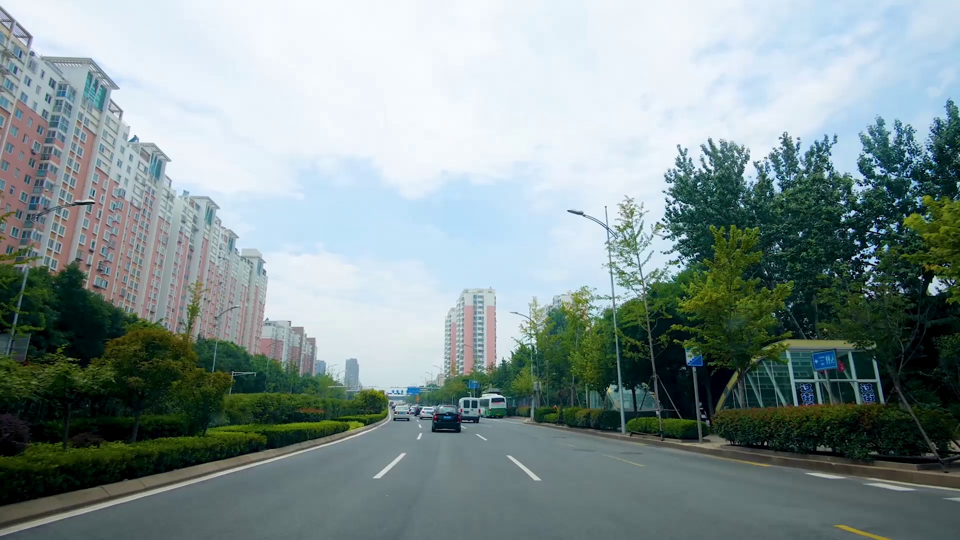

In [5]:
origin_img

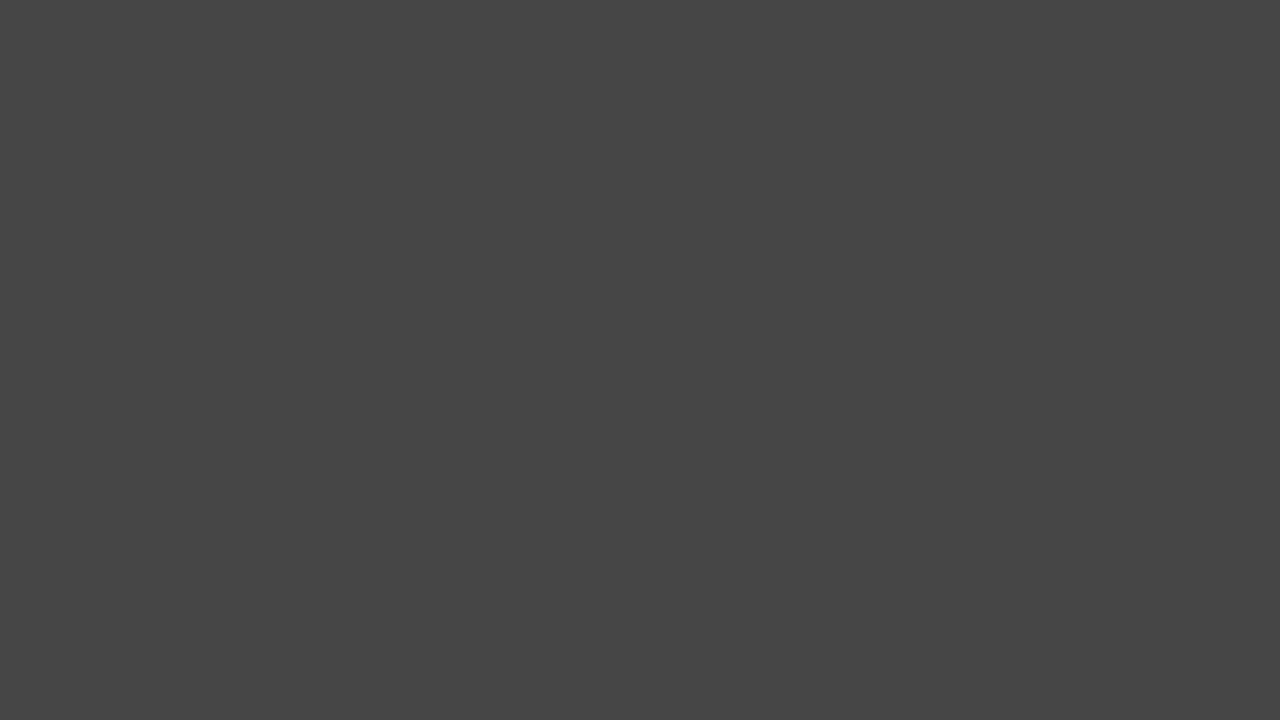

In [13]:
color_pic = colorize(mask.cpu())
torchvision.transforms.functional.to_pil_image(color_pic)